# Procedure

## 1 Crop to tray and corn
Input: filepath  
Output: Cropped tray image

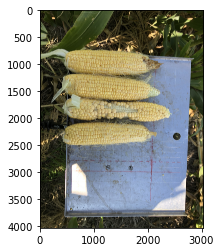

In [1]:
# Necessary imports
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

example = imread("../data/images/IMG_8302.jpg")
#example = imread("../data/images/Tray Photos NA/IMG_8313.JPG") # insect damaged
#example = imread("../data/images/Tray Photos NA/IMG_1041.jpg") # ghostly corn

#example = imread("../data/images/Tray Photos EAME/IMG_6830.JPG")
plt.imshow(example)

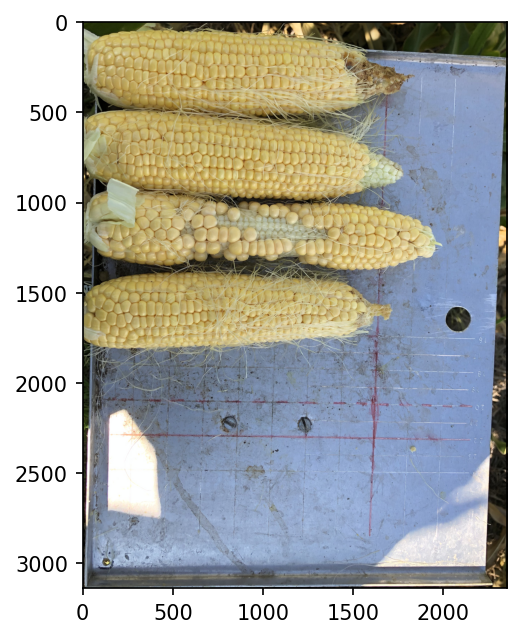

In [2]:
from skimage.color import rgb2hsv
from skimage import morphology
from scipy import ndimage

def crop_by_mask(image, mask):
    """
    Takes an image and a binary mask and outputs an image cropped to the contents of the binary mask
    """
    chull = morphology.convex_hull_image(mask)
    if chull.any():
        [rows, columns] = np.where(chull)
        row1 = min(rows)
        row2 = max(rows)
        col1 = min(columns)
        col2 = max(columns)
        return image[row1:row2, col1:col2]
    else:
        return None

def hsv_threshold(im, hmin=-0.01,hmax=1.0, smin=-0.01,smax=1.0, vmin=-0.01,vmax=1.0, plot=True):
    """
    Threshold an image with appropriate h,s,v values
    """
    h = im[:,:,0]
    s = im[:,:,1]
    v = im[:,:,2]
    b_img = ((h > hmin) & (h <= hmax) &
             (s > smin) & (s <= smax) &
             (v > vmin) & (v <= vmax))
    if plot:
        plt.figure(figsize = (10,20))
        plt.imshow(b_img, cmap='gray', vmin=0, vmax=1, interpolation='nearest') # interpolation=nearest prevents matplotlib from "smoothing" the edges out
        plt.show()
    return b_img*1

def mask_hsv_filter(image, hsv_filter):
    hsv_image = rgb2hsv(image)
    mask = hsv_threshold(hsv_image, **hsv_filter, plot=False)
    
    opened = ndimage.binary_opening(mask, iterations=10)
    cleaned = morphology.remove_small_objects(opened != 0, 500000)
    dilated = ndimage.binary_dilation(cleaned,iterations=10)
    
    return dilated

def crop_to_tray(image):
    tray_filter = {
        'hmin' : -0.01,
        'hmax' : 1.01,
        'smin' : -0.01,
        'smax' : 0.36,
        'vmin' : 0.45,
        'vmax' : 1.01
    }

    corn_filter = {
        'hmin' : 0.10,
        'hmax' : 0.20,
        'smin' : 0.36,
        'smax' : 1.01,
        'vmin' : 0.23,
        'vmax' : 1.01
    }
    mask = mask_hsv_filter(image, tray_filter) | mask_hsv_filter(image, corn_filter)
    return crop_by_mask(image, mask)

cropped_example = crop_to_tray(example)
plt.figure(figsize=(5,5), dpi=150)
plt.imshow(cropped_example)

## 2 Segment corn
Input: Cropped tray image  
Output: Mask with corn

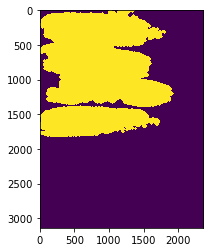

In [3]:
from skimage import exposure
from skimage.color import rgb2hsv

def jkmr_mask(image):
    """
    From Miles' code modified by Joshua
    """
    hmin = -0.01
    hmax = 0.15
    smin = 0.30
    smax = 0.70
    vmin = 0.50
    vmax = 1.01


    hsv = rgb2hsv(image)
    h = hsv[:,:,0];
    s = hsv[:,:,1];
    v = hsv[:,:,2];

    # trick because the color space wraps
    if hmin > hmax:
        b_img = (h > hmin) | (h < hmax)
    else:
        b_img = (h > hmin) & (h < hmax);
    
    b_img = (b_img & 
    (s > smin) & (s < smax) & 
    (v > vmin) & (v < vmax));

    b1 = ndimage.binary_erosion(b_img, iterations = 5)
    b2 = ndimage.binary_dilation(b1, iterations = 30)
    b3 = ndimage.binary_erosion(b2, iterations = 5)
    
    return b3

better_corn_segmentation = jkmr_mask(cropped_example)
best = morphology.remove_small_objects(better_corn_segmentation, 100000)
best = morphology.remove_small_holes(best, 125000)
plt.imshow(best, interpolation='nearest')

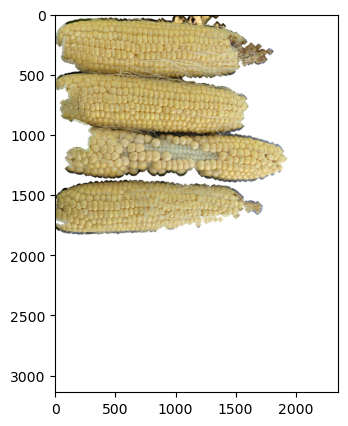

In [4]:
copy = cropped_example.copy()
copy[~best] = 255
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(copy)

### A different approach...
Filtering approaches can work but ultimately, you're going to be tweaking values to work just right.
I'm not sure if this is a real thing that image analysis people do, but I thought to instead make a bunch of filters that capture different aspects (e.g. one for the darker, one for lighter, one for more saturated, etc) and compute how much overlap there is between those regions and use the regions with some threshold of support.

In [5]:
from skimage.color import rgb2lab
from skimage import filters

def filter_1(image, hsv_image, lab_image):
    t1=filters.threshold_isodata(hsv_image[:,:,0])
    t2=filters.threshold_isodata(hsv_image[:,:,1])
    t3=filters.threshold_isodata(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    return binary_image

def filter_2(image, hsv_image, lab_image):
    t1=filters.threshold_minimum(hsv_image[:,:,0])
    t2=filters.threshold_minimum(hsv_image[:,:,1])
    t3=filters.threshold_minimum(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    binary_image = morphology.remove_small_objects(binary_image, 70000)
    return binary_image

def filter_3(image, hsv_image, lab_image):
    t1=filters.threshold_mean(image[:,:,0])
    t3=filters.threshold_mean(image[:,:,2])
    binary_image = (image[:,:,0] > t1) & (image[:,:,2] < t3)
    binary_image = morphology.remove_small_objects(binary_image, 70000)
    return binary_image

def filter_4(image, hsv_image, lab_image):
    t1=filters.threshold_mean(lab_image[:,:,0])
    t2=filters.threshold_mean(lab_image[:,:,1])
    t3=filters.threshold_mean(lab_image[:,:,2])
    binary_image = (lab_image[:,:,0] < t1) & (lab_image[:,:,1] > t2) & (lab_image[:,:,2] > t3)
    binary_image = ndimage.binary_dilation(binary_image, iterations=3)
    binary_image = morphology.remove_small_objects(binary_image, 30000)
    binary_image = ndimage.binary_erosion(binary_image)
    return binary_image

def filter_5(image, hsv_image, lab_image):
    t1=filters.threshold_yen(hsv_image[:,:,0])
    t2=filters.threshold_yen(hsv_image[:,:,1])
    t3=filters.threshold_yen(hsv_image[:,:,2])
    binary_image = (hsv_image[:,:,0] < t1) & (hsv_image[:,:,1] > t2) & (hsv_image[:,:,2] > t3)
    return binary_image

def filter_6(image, hsv_image, lab_image):
    t1=filters.threshold_sauvola(lab_image[:,:,1])
    t2=filters.threshold_sauvola(lab_image[:,:,2])
    t3=filters.threshold_sauvola(hsv_image[:,:,0])
    binary_image = (lab_image[:,:,1] < t1) & (lab_image[:,:,2] < t2) & (hsv_image[:,:,0] > t3)
    binary_image = ndimage.binary_erosion(binary_image, iterations=3)
    binary_image = ndimage.binary_dilation(binary_image, iterations=2)
    binary_image = morphology.remove_small_objects(binary_image, 20000)
    return binary_image

def filter_7(image, hsv_image, lab_image):
    lab_image = rgb2lab(image)
    hsv_image = rgb2hsv(image)
    t1=filters.threshold_li(lab_image[:,:,2])
    t2=filters.threshold_li(hsv_image[:,:,0])
    t3=filters.threshold_li(hsv_image[:,:,1])
    t4=filters.threshold_yen(lab_image[:,:,0])
    binary_image = (lab_image[:,:,2] > t1) & (hsv_image[:,:,0] < t2) & (hsv_image[:,:,1] > t3) & (lab_image[:,:,0] > t4)
    binary_image = morphology.area_closing(binary_image, area_threshold=512)
    binary_image = morphology.remove_small_objects(binary_image, 4096)
    return binary_image

def multimask_support(image, filter_functions):
    support = np.zeros((image.shape[0],image.shape[1]))
    hsv_image = rgb2hsv(image)
    lab_image = rgb2lab(image)
    for ff in filter_functions:
        support += ff(image, hsv_image, lab_image)
    return support

filter_functions = [filter_1, 
                    filter_2, 
                    filter_3, 
                    filter_4, 
                    filter_5, 
                    filter_6,
                    filter_7]

support = multimask_support(cropped_example, filter_functions)

Text(0.5, 1.0, "Consensus or'd with MJ mask")

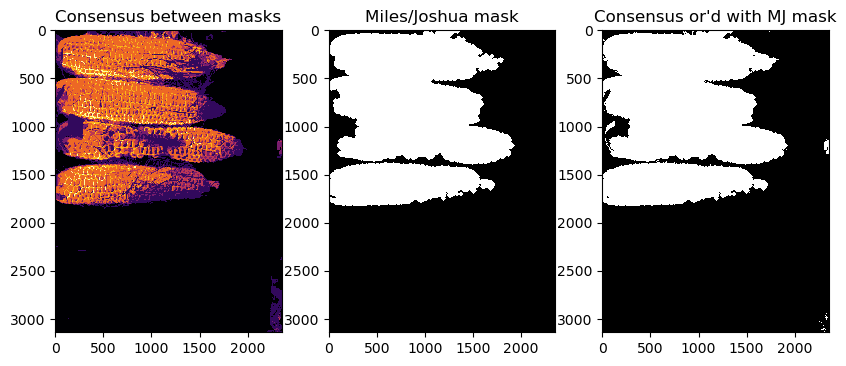

In [6]:
fig, axs = plt.subplots(1,3, figsize=(10,4), dpi=100)
axs[0].imshow(support, interpolation='nearest', cmap='inferno')
axs[0].set_title("Consensus between masks")
axs[1].imshow(best, interpolation='nearest', cmap='gray')
axs[1].set_title("Miles/Joshua mask")
axs[2].imshow((support > 1) | best, interpolation='nearest', cmap='gray')
axs[2].set_title("Consensus or'd with MJ mask")

In [7]:
maybe_better = best | (support > 1)
maybe_better = morphology.area_closing(maybe_better, area_threshold=40000)
maybe_better = morphology.remove_small_objects(maybe_better, 10000)

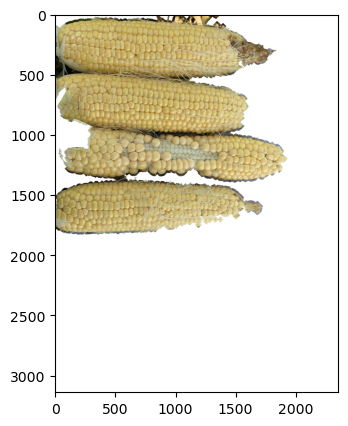

In [8]:
copy = cropped_example.copy()
copy[~maybe_better] = 255
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(copy)

## 3 Detect insect damage
Input: Masked corn  
Output: Classification (damage present? how much?)

In [9]:
from matplotlib import colors

def find_damage(image, corn_mask):
    hsv = colors.rgb_to_hsv(image)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    hmin = 0.8
    hmax = 0.21
    vmin = 60
    vmax = 140
    smin = 0.2
    smax = 0.7
    
    b_img = corn_mask
    # trick because the color space wraps
    if hmin > hmax:
        b_img &= (h > hmin) | (h < hmax)
    else:
        b_img &= (h > hmin) & (h < hmax)
    
    b_img = (b_img & 
        (s > smin) & (s < smax) & 
        (v > vmin) & (v < vmax))
    b_img = ndimage.binary_dilation(b_img, iterations=4)
    b_img = morphology.remove_small_objects(b_img, 20000)
    b_img = ndimage.binary_erosion(b_img, iterations=1)
    return b_img


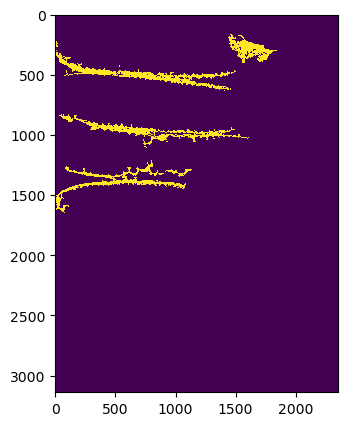

In [10]:
plt.figure(figsize=(5,5), dpi=100)
damage_mask = find_damage(cropped_example, maybe_better)
plt.imshow(damage_mask, interpolation='Nearest')

## 4 Differentiate between damage and not damage

In [11]:
from skimage import measure
blobs=damage_mask
blobs_labels = measure.label(blobs, background=0)

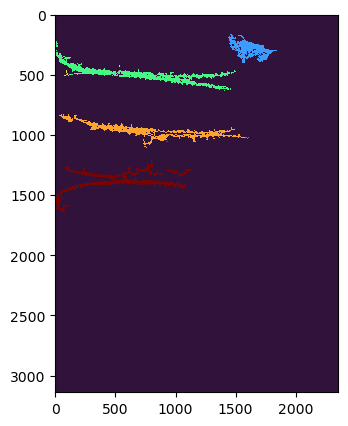

In [12]:
plt.figure(figsize=(5,5), dpi=100)
blobs_hmm = blobs_labels.copy()
blobs_hmm[np.where(blobs_hmm > 0)] += 1
plt.imshow(blobs_hmm, interpolation='nearest', cmap='turbo')

In [13]:
num_labels = blobs_labels.max()
big_blobs = []
for i in range(num_labels):
    blob_mask = blobs_labels == i+1
    blob_mask = morphology.remove_small_holes(blob_mask, 150)
    if (blob_mask.sum() > 2000):
        big_blobs.append(blob_mask)

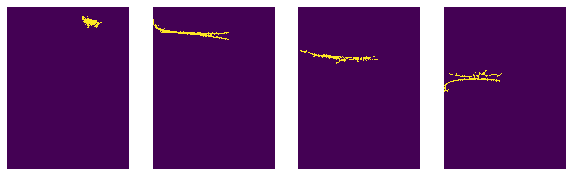

In [14]:
num_big_blobs = len(big_blobs)
fig, axs = plt.subplots(1, num_big_blobs, figsize=(num_big_blobs * 2.5, 3))
for i in range(num_big_blobs):
    axs[i].imshow(big_blobs[i], interpolation='nearest')
    axs[i].axis('off')

2.33, 0.65
10.99, 0.24
11.74, 0.29
4.49, 0.19


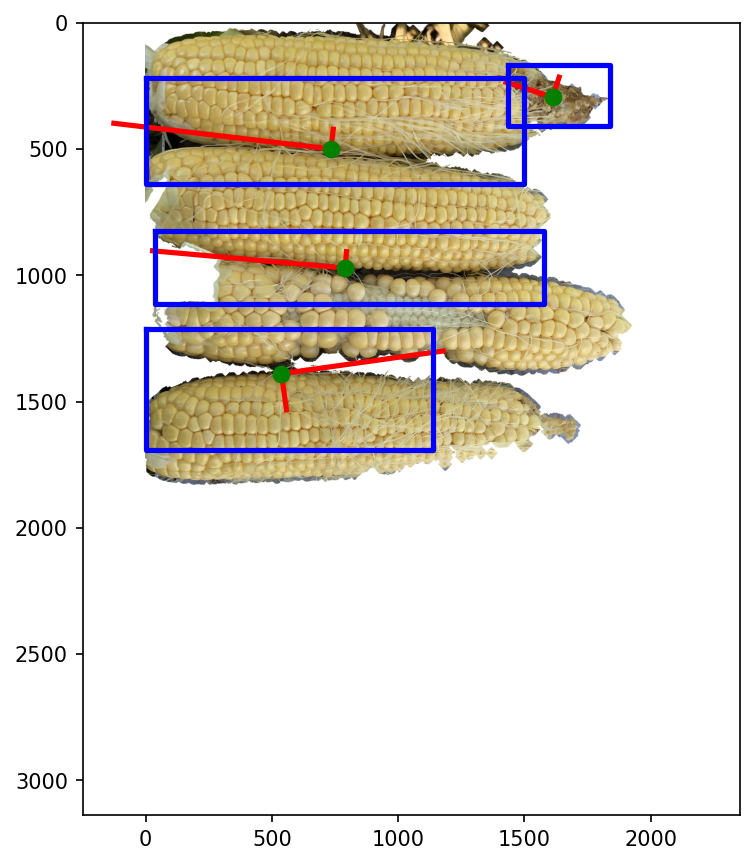

In [15]:
from skimage import measure
from skimage import transform
import math

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
ax.imshow(copy)
for blob in big_blobs:
    labeled = measure.label(blob)
    regions = measure.regionprops(labeled)
    for props in regions:
        # This code is lifted from:
        # https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py
        y0, x0 = props.centroid
        metric_1 = props.major_axis_length / props.minor_axis_length
        metric_2 = props.solidity
        print(f"{metric_1:.02f}, {metric_2:.02f}")
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=2.5)

In [16]:
possible_damage = []
for blob in big_blobs:
    labeled = measure.label(blob)
    regions = measure.regionprops(labeled)
    solidity = regions[0].solidity
    if solidity > 0.5:
        possible_damage.append(blob)

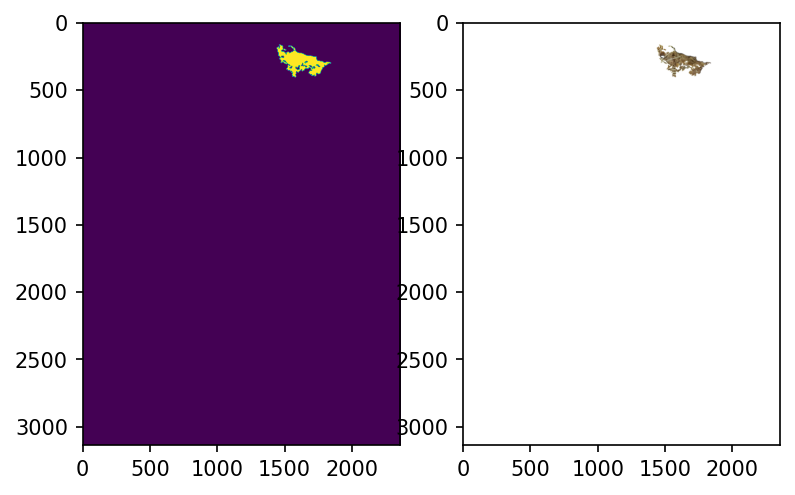

In [17]:
potential_damage_mask = np.zeros(np.shape(maybe_better))
for d in possible_damage:
    potential_damage_mask = potential_damage_mask.astype(bool) | d
fig, axs = plt.subplots(1,2, dpi=150)
axs[0].imshow(potential_damage_mask)
copy = cropped_example.copy()
copy[~potential_damage_mask] = 255
axs[1].imshow(copy)

## Writing some functions for things we did before

In [18]:
def segment_corn(image):
    better_corn_segmentation = jkmr_mask(image)
    best = morphology.remove_small_objects(better_corn_segmentation, 100000)
    best = morphology.remove_small_holes(best, 125000)
    filter_functions = [filter_1, 
                        filter_2, 
                        filter_3, 
                        filter_4, 
                        filter_5, 
                        filter_6,
                        filter_7]
    support = multimask_support(image, filter_functions)
    binary_image = best | (support > 1)
    binary_image = morphology.area_closing(binary_image, area_threshold=40000)
    binary_image = morphology.remove_small_objects(binary_image, 10000)
    return binary_image

In [19]:
def filter_non_damage(damage_mask):
    blobs_labels = measure.label(damage_mask, background=0)
    
    num_labels = blobs_labels.max()
    big_blobs = []
    for i in range(num_labels):
        blob_mask = blobs_labels == i+1
        blob_mask = morphology.remove_small_holes(blob_mask, 150)
        if (blob_mask.sum() > 2000):
            big_blobs.append(blob_mask)
    #print(f'Number of big blobs before filtering: {len(big_blobs)}')
    possible_damage = []
    for blob in big_blobs:
        labeled = measure.label(blob)
        regions = measure.regionprops(labeled)
        solidity = regions[0].solidity
        Mm_proportion = regions[0].major_axis_length / regions[0].minor_axis_length
        #print("solidity:",solidity)
        #print(f"major / minor axis: {Mm_proportion}")
        if solidity > 0.43 and Mm_proportion < 3:
            possible_damage.append(blob)
    return possible_damage

# Assembling a single function to detect damage


In [33]:
def potential_damage(image):
    fig, axs = plt.subplots(1,4, figsize=(15,4), dpi=100)
    # 1 Crop to tray and corn
    cropped_image = crop_to_tray(image)
    axs[0].imshow(cropped_image)
    axs[0].set_title("Cropped Image")
    # 2 Segment corn
    corn_mask = segment_corn(cropped_image)
    axs[1].imshow(corn_mask, interpolation='nearest')
    axs[1].set_title("Corn mask")
    
    # 3 Detect insect damage
    damage_mask = find_damage(cropped_image, corn_mask)
    axs[2].imshow(damage_mask, interpolation='nearest')
    axs[2].set_title("Damage mask")
    
    # 4 Filter based on shape
    potential_damage = filter_non_damage(damage_mask)
    all_damage = np.zeros(damage_mask.shape).astype(bool)
    for potdam in potential_damage:
        all_damage = all_damage | potdam.astype(bool)
    
    copied_im = cropped_image.copy()
    copied_im[:,:,0][all_damage] = 255
    axs[3].imshow(copied_im, interpolation='nearest')
    axs[3].set_title("Filtered damage mask")
    
    return cropped_image, all_damage

Number of big blobs before filtering: 4


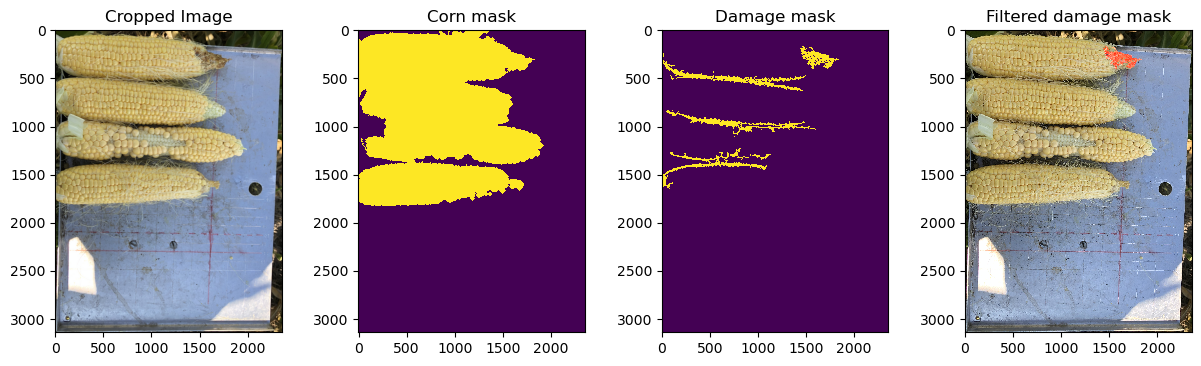

In [34]:
cropped_im, damage = potential_damage(example)

## Now let's try it on a completely different image

Number of big blobs before filtering: 3


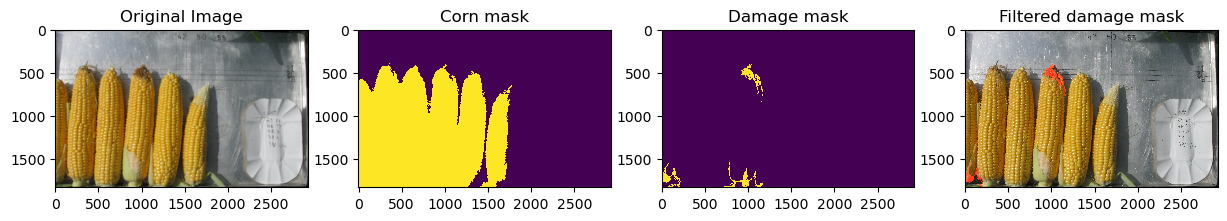

In [26]:
unseen = imread("../data/images/Tray Photos EAME/IMG_6830.JPG")
cropped_im, damage = potential_damage(unseen)

Number of big blobs before filtering: 8


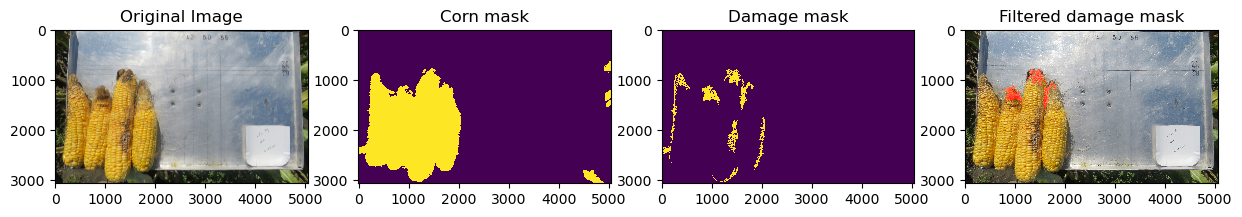

In [27]:
unseen2 = imread("../data/images/Tray Photos EAME/IMG_8143.JPG")
cropped_im2, damage2 = potential_damage(unseen2)

/home/rei/anaconda3/envs/CSS844/lib/python3.8/site-packages/skimage/filters/thresholding.py:505: RuntimeWarning: divide by zero encountered in true_divide
  higher = (csum_intensity[-1] - csum_intensity[:-1]) / csumh[:-1]
/home/rei/anaconda3/envs/CSS844/lib/python3.8/site-packages/skimage/filters/thresholding.py:409: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


Number of big blobs before filtering: 9


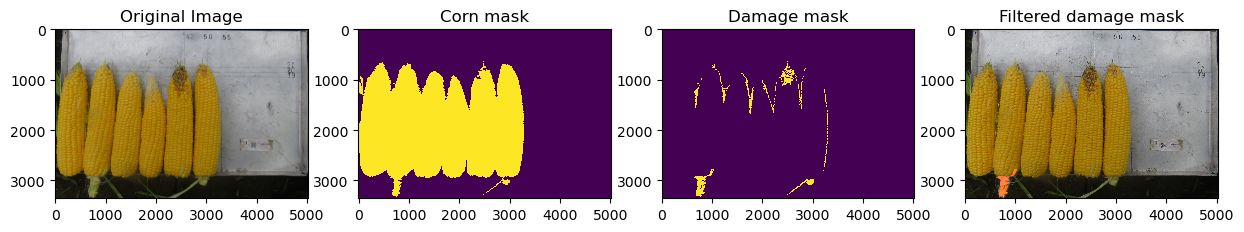

In [28]:
unseen3 = imread("../data/images/Tray Photos EAME/IMG_8430.JPG")
cropped_im3, damage3 = potential_damage(unseen3)

Number of big blobs before filtering: 9


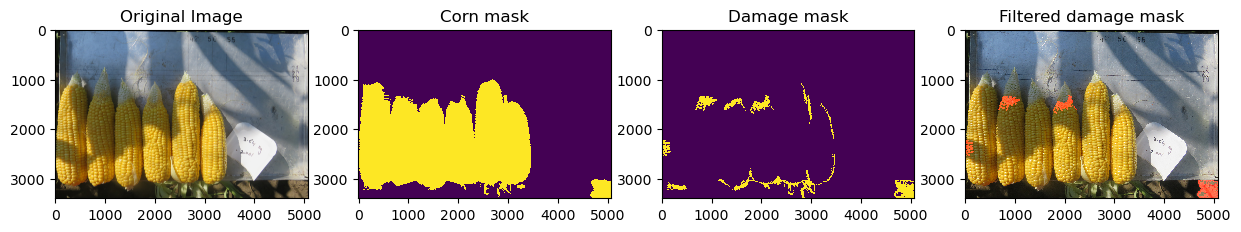

In [29]:
unseen4 = imread("../data/images/Tray Photos EAME/IMG_8474.JPG")
cropped_im4, damage4 = potential_damage(unseen4)

Number of big blobs before filtering: 6


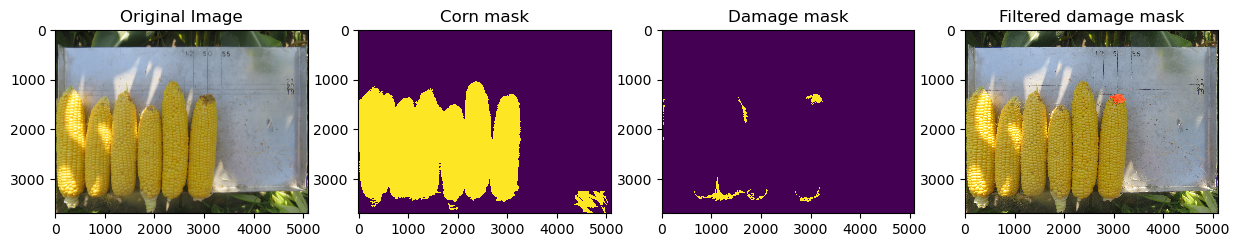

In [30]:
unseen5 = imread("../data/images/Tray Photos EAME/IMG_8513.JPG")
cropped_im5, damage5 = potential_damage(unseen5)

Number of big blobs before filtering: 7


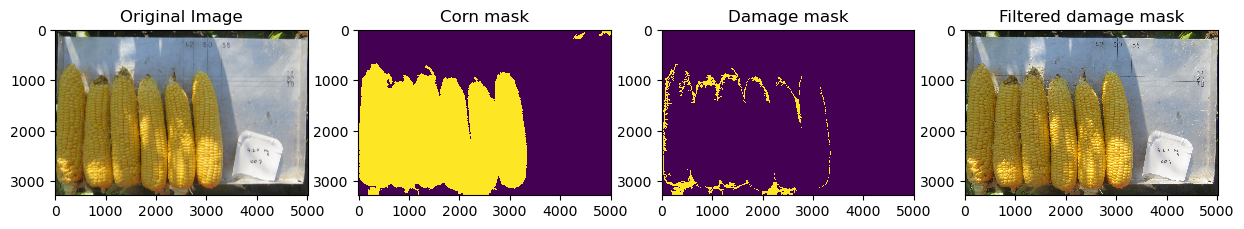

In [31]:
unseen_imdone = imread("../data/images/Tray Photos EAME/IMG_8515.JPG")
cropped_6, d6 = potential_damage(unseen_imdone)